# Advanced Seminar Code

## Table of Contents

0. Initial Setup
1. Data Generation
2. Matching Availability of Patient and Bed
3. Class Generation for Each Patient and Bed
4. Class Generation to Confirm Schedules with First-Come-First-Serve (FCFS) and Multi-Appointment Scheduling
5. First-Class-First-Serve Approach to Confirm Schedules
6. Simulated Annealing Approach
7. Multi-Appointment Scheduling with Simulated Annealing
8. Evaluation of Results of FCFS and Multi-Appointment Scheduling

## 0. Initial Setup

In [1]:
# Import standard packages
import csv
from datetime import datetime
import time
import random
import math
from math import e
import copy

In [2]:
# import third-party packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# import local library imports
from calculate_value import *
from data_generation import *
from matched_availability import *
from schedule_appointment import * 

## 1. Data Generation

Each instance is characterized by three parameters ( r, κ, δ), where r is patient to bed ratio, κ is the number of slots per hour (larger κresults in shorter time slots and therefore patients will have more flexibility in selecting their available/target times), and finally, δ is the maximum allowable deviation from patient target times (presented in the number of slots). We generate m =   r ∗ n   instances, where n is the number of available beds and m is the number of patients.

Similar to a typical hemodialysis center, we consider 14 hours per day and 6 days per week (8:00 AM to 10:00 PM; Monday–Saturday). Patient available times for each day are generated independently. We split each day into two parts: morning and evening. Slots in each part of the day have an equal chance to be selected by patients (50% chance). More precisely, each day is composed of 14 ∗δslots. If a patient is available in the morning of a specific day (with 50% chance), then their ideal time slot is a random slot selected from { 1 , 2 , . . . , (14 ∗ κ) / 2 } . Likewise, if the patient is avail- able in the evening, his ideal time slot is randomly selected from { ((14 ∗ κ) / 2 ) + 1 , ((14 ∗ κ) / 2) + 2 , . . . , 14 ∗κ} . In case the selected evening slot doesn’t allow for a feasible dialysis appointment, a new slot is ran- domly selected. Note that it is possible that a patient is available in both parts of the day (with a 25% chance), i.e., the patient has two ideal time slots. In this case one appointment can be sched- uled in either of the slots (please note the one-day time separation between patient’s consecutive appointments). Dialysis treatment times are 4 hours, to comply with the average reported length of hemodialysis treatment. 6 We randomly generate three different priority weights for patients. Every patient jhas ζk chance of having priority k ∈ { 1 , 2 , 3 } , thus, receiving a w k j weight in the objec- tive function. We consider ζ1 = 0 . 6 , w 1 = 1 ; ζ2 = 0 . 25 , w 2 = 1 . 4 ; and ζ3 = 0 . 15 , w 3 = 2 .

In the United States, a typical hemodialysis center, includ- ing our collaborating hemodialysis center, has approximately four hemodialysis patients per bed per day ( System, 2013 ). Consider- ing the expected growth in the demand for dialysis ( Medicare Pay- ment Advisory Commission, 2021 ), we evaluate the performance of our proposed BP algorithms for two patient-to-bed ratios of 4 and 5. For each patient-to-bed ratio, we consider time slot settings of 1 slot per hour and 2 slots per hour (half-hour slots). For each ratio-slot combination, we consider three maximum allowable de- viations from target times of 1 slot, 2 slots, and 4 slots. In terms of bed-patient size, the smallest instance starts with 10 beds and 40 patients, and the largest size represents a hemodialysis center with 20 beds and 100 patients. For every configuration in our test data set, we randomly generate 5 instances, resulting in a total of 270 instances, and report the average of 5 instances and the worst case for each configuration. 7

### 1a. Define some initial variables

I define some initial variables for to set, that can be changed and generate different outcomes. 

#### 1ai. Variables that can be changed to create different graphs. 

In [4]:
## DECISION VARIABLES
# n = number of available beds
num_beds = 2
# m = number of patients
num_patients = 8

## VARIABLE RELATED TO THE DEVIATION 
# δ = maximum allowed deviation from patient target times based on number of slots
max_allowed_deviation = 4

### 1aii. Variables that may be possible to change though with limited functionality

The variabels below can be changed from the default, though I did not thoroughly test them so I cannot guarantee if the code will work if these variables are changed. 

In [5]:
## VARIABLES RELATED TO TIME
# κ = number of slots per hour , should not be over than 4! This is recommended from paper of Reihaneh et al.
num_of_slots_per_hour = 1
# Based on pg 37 of Rehihnahe et al. this is usually 3 required dialysis essions
num_required_dialysis_sessions = 3
# number of days per week
num_days_per_week = 6
# each day is composed of 14 hours per day ∗ δ slots
num_slots_per_day = 14 * num_of_slots_per_hour

### 1b. Define an empty list containing all available time slots

Reihaneh et al.: For example, assuming 8 AM as the earliest availability of beds for K = 1, dialysis can only be scheduled at {8, 9, 10,..,} whereas for k = 4, dialysis may begin at {8, 8:15, 8:30, 9:00, 9:15, .. }. In this paper we consider K 
tion of time (i.e., .> 4 ) causes an exponential increase in solution
space, which is not justified as the average dialysis appointment
usually lasts 4 hours, and 5–10 minutes deviation does not affect
the show-up probability of patients.

In [6]:
# define a the list of open time slots based on the num of slots per hour. 
available_time_slot_list = []

Create a list of open time slots that will be used to create the schedule for the patients. As an example, the resulting open time slot list 
will be something like [830, 900, 930,..] assuming that there are 2 slots per hour, and 14 working hours per day. We assume that the possible 
maximum number of slots per hour is only 4 based on the approach of Reihaneh et al.

In [7]:
available_time_slot_list = generate_available_time_slots(num_slots_per_day, num_of_slots_per_hour)

In [8]:
available_time_slot_list

[800,
 900,
 1000,
 1100,
 1200,
 1300,
 1400,
 1500,
 1600,
 1700,
 1800,
 1900,
 2000,
 2100,
 2200]

### 1c. Define a list of random-generated priorities and assigned to the patients

This concept is based on Reihaneh et al.'s: I randomly generate three different priority weights for patients. Every patient jhas ζk chance of having priority k ∈ { 1 , 2 , 3 } , thus, receiving a w_j^k weight in the objective function. We consider ζ1 = 0 . 6 , w 1 = 1 ; ζ2 = 0 . 25 , w 2 = 1 . 4 ; and ζ3 = 0 . 15 , w 3 = 2 .

In [9]:
# Define the priority that the patient should be assigned and the probability of the patient getting them
priority = [1,2,3]
probabilities = [0.6, 0.25, 0.15]

In [10]:
random_priority = []
random_priority = generate_patient_random_priority(num_patients, priority, probabilities)

In [11]:
# Each item in the list represents a single patient, with the first one being patient 1 with index 0 in the list
random_priority

[2, 3, 1, 2, 2, 3, 3, 2]

### 1d. Define the prescribed dialysis hours

In [12]:
prescribed_dialysis_hours_list = []
prescribed_dialysis_hours_list = generate_prescribed_dialysis_hours(num_patients)

In [13]:
prescribed_dialysis_hours_list

[12, 9, 9, 12, 15, 9, 12, 9]

### 1e. Create functions to set up a randomized dictionary to assign the availability of the patient and bed

Each patient will have an name, ideal schedule, priority, and weight

#### 1ei. Function to create the initial empty dict with available time slots for the patient and bed

if num of slots per hour == 1:
   then append all the hours to 00
if num of slots per hour > 1:


In [14]:
# Give higher preference to giving availability so generating 1
not_available = 0
available = 1

probabilities_availability = [0.8, 0.2]

random_number = random.choices([available, not_available], probabilities_availability)[0]

In [15]:
# Put the patient profiles in a list to grab them more easily so here I initiate an empty patient list
# All_patients_availability_list is a list of patient profile dictionaries. The ideal_schedule is also a dictionary
all_beds_availablity_list = []

# Append the patient profiles into the list
for bed in range(0, num_beds):
    all_beds_availablity_list.append(create_bed_profile(bed, available_time_slot_list))

In [16]:
all_beds_availablity_list

[{'bed': 'b1',
  'bed_availability': {1: {800: 0,
    900: 0,
    1000: 0,
    1100: 0,
    1200: 0,
    1300: 0,
    1400: 0,
    1500: 0,
    1600: 0,
    1700: 0,
    1800: 0,
    1900: 0,
    2000: 0,
    2100: 0,
    2200: 0},
   2: {800: 0,
    900: 0,
    1000: 0,
    1100: 0,
    1200: 0,
    1300: 0,
    1400: 0,
    1500: 0,
    1600: 0,
    1700: 0,
    1800: 0,
    1900: 0,
    2000: 0,
    2100: 0,
    2200: 0},
   3: {800: 0,
    900: 0,
    1000: 0,
    1100: 0,
    1200: 0,
    1300: 0,
    1400: 0,
    1500: 0,
    1600: 0,
    1700: 0,
    1800: 0,
    1900: 0,
    2000: 0,
    2100: 0,
    2200: 0},
   4: {800: 0,
    900: 0,
    1000: 0,
    1100: 0,
    1200: 0,
    1300: 0,
    1400: 0,
    1500: 0,
    1600: 0,
    1700: 0,
    1800: 0,
    1900: 0,
    2000: 0,
    2100: 0,
    2200: 0},
   5: {800: 0,
    900: 0,
    1000: 0,
    1100: 0,
    1200: 0,
    1300: 0,
    1400: 0,
    1500: 0,
    1600: 0,
    1700: 0,
    1800: 0,
    1900: 0,
    2000: 0,
    210

#### 1eii. Create dictionary profile for the patient

In [17]:
# put the patient profiles in a list to grab them more easily so here I initiate an empty patient list
# patients_list is a list of patient profile dictionaries. The ideal_schedule is also a dictionary
all_patients_availability_list = []

# append the patient profiles into the list
for patient in range(0, num_patients):
    print(patient)
    all_patients_availability_list.append(create_patient_profile(patient, available_time_slot_list, random_priority, prescribed_dialysis_hours_list))

0
1
2
3
4
5
6
7


In [18]:
all_patients_availability_list

[{'patient': 'p1',
  'priority': 2,
  'weight': 1.4,
  'prescribed_dialysis_hours': 12,
  'patient_availability': {1: {800: 1,
    900: 0,
    1000: 0,
    1100: 0,
    1200: 1,
    1300: 1,
    1400: 0,
    1500: 0,
    1600: 0,
    1700: 0,
    1800: 1,
    1900: 0,
    2000: 1,
    2100: 1,
    2200: 0},
   2: {800: 1,
    900: 1,
    1000: 0,
    1100: 1,
    1200: 0,
    1300: 1,
    1400: 0,
    1500: 0,
    1600: 1,
    1700: 0,
    1800: 0,
    1900: 0,
    2000: 1,
    2100: 0,
    2200: 1},
   3: {800: 1,
    900: 1,
    1000: 1,
    1100: 0,
    1200: 1,
    1300: 1,
    1400: 0,
    1500: 1,
    1600: 0,
    1700: 1,
    1800: 1,
    1900: 0,
    2000: 0,
    2100: 0,
    2200: 1},
   4: {800: 0,
    900: 0,
    1000: 0,
    1100: 1,
    1200: 1,
    1300: 0,
    1400: 0,
    1500: 1,
    1600: 1,
    1700: 1,
    1800: 1,
    1900: 1,
    2000: 1,
    2100: 0,
    2200: 1},
   5: {800: 0,
    900: 0,
    1000: 1,
    1100: 0,
    1200: 1,
    1300: 1,
    1400: 1,
    1500

## 2. Matching Availability of Patient and Bed

### 2a. Create dictionary of where the availabilities of the bed and patient match

In [19]:
# define a list of cases when the availablity of the patient and bed match
all_patients_matched_availability = match_bed_patient_availability(all_patients_availability_list, all_beds_availablity_list)

# Print the updated all_patients_matched_availability
for entry in all_patients_matched_availability:
    print(entry)


p1
day  1
day  2
day  3
day  4
day  5
day  6
p2
day  1
day  2
day  3
day  4
day  5
day  6
p3
day  1
day  2
day  3
day  4
day  5
day  6
p4
day  1
day  2
day  3
day  4
day  5
day  6
p5
day  1
day  2
day  3
day  4
day  5
day  6
p6
day  1
day  2
day  3
day  4
day  5
day  6
p7
day  1
day  2
day  3
day  4
day  5
day  6
p8
day  1
day  2
day  3
day  4
day  5
day  6
{'patient': 'p1', 'bed': 'b1', 'matched_availability': {1: {900: 0, 1000: 0, 1100: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 0, 1900: 0, 2200: 0}}}
{'patient': 'p1', 'bed': 'b2', 'matched_availability': {1: {900: 0, 1000: 0, 1100: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 0, 1900: 0, 2200: 0}}}
{'patient': 'p1', 'bed': 'b1', 'matched_availability': {2: {1000: 0, 1200: 0, 1400: 0, 1500: 0, 1700: 0, 1800: 0, 1900: 0, 2100: 0}}}
{'patient': 'p1', 'bed': 'b2', 'matched_availability': {2: {1000: 0, 1200: 0, 1400: 0, 1500: 0, 1700: 0, 1800: 0, 1900: 0, 2100: 0}}}
{'patient': 'p1', 'bed': 'b1', 'matched_availability': {3: {1100: 0, 1400: 0, 1600: 0, 1

#### 2ai. Consolidate the list together to get a combination of patients and beds

In [20]:
patients_beds_combo_consolidated_dict = get_combination_patients_beds(all_patients_matched_availability)

# Print the consolidated dictionary
for entry in patients_beds_combo_consolidated_dict.values():
    print(entry)


{'patient': 'p1', 'bed': 'b1', 'matched_availability': {1: {900: 0, 1000: 0, 1100: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 0, 1900: 0, 2200: 0}, 2: {1000: 0, 1200: 0, 1400: 0, 1500: 0, 1700: 0, 1800: 0, 1900: 0, 2100: 0}, 3: {1100: 0, 1400: 0, 1600: 0, 1900: 0, 2000: 0, 2100: 0}, 4: {800: 0, 900: 0, 1000: 0, 1300: 0, 1400: 0, 2100: 0}, 5: {800: 0, 900: 0, 1100: 0, 1700: 0, 2000: 0}, 6: {900: 0, 1000: 0, 1100: 0, 1900: 0, 2100: 0}}}
{'patient': 'p1', 'bed': 'b2', 'matched_availability': {1: {900: 0, 1000: 0, 1100: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 0, 1900: 0, 2200: 0}, 2: {1000: 0, 1200: 0, 1400: 0, 1500: 0, 1700: 0, 1800: 0, 1900: 0, 2100: 0}, 3: {1100: 0, 1400: 0, 1600: 0, 1900: 0, 2000: 0, 2100: 0}, 4: {800: 0, 900: 0, 1000: 0, 1300: 0, 1400: 0, 2100: 0}, 5: {800: 0, 900: 0, 1100: 0, 1700: 0, 2000: 0}, 6: {900: 0, 1000: 0, 1100: 0, 1900: 0, 2100: 0}}}
{'patient': 'p2', 'bed': 'b1', 'matched_availability': {1: {1000: 0, 1100: 0, 1200: 0, 1300: 0, 1500: 0, 1700: 0, 1800: 0}, 2: {1000: 0,

In [21]:
all_patients_matched_availability

[{'patient': 'p1',
  'bed': 'b1',
  'matched_availability': {1: {900: 0,
    1000: 0,
    1100: 0,
    1400: 0,
    1500: 0,
    1600: 0,
    1700: 0,
    1900: 0,
    2200: 0},
   2: {1000: 0, 1200: 0, 1400: 0, 1500: 0, 1700: 0, 1800: 0, 1900: 0, 2100: 0},
   3: {1100: 0, 1400: 0, 1600: 0, 1900: 0, 2000: 0, 2100: 0},
   4: {800: 0, 900: 0, 1000: 0, 1300: 0, 1400: 0, 2100: 0},
   5: {800: 0, 900: 0, 1100: 0, 1700: 0, 2000: 0},
   6: {900: 0, 1000: 0, 1100: 0, 1900: 0, 2100: 0}}},
 {'patient': 'p1',
  'bed': 'b2',
  'matched_availability': {1: {900: 0,
    1000: 0,
    1100: 0,
    1400: 0,
    1500: 0,
    1600: 0,
    1700: 0,
    1900: 0,
    2200: 0},
   2: {1000: 0, 1200: 0, 1400: 0, 1500: 0, 1700: 0, 1800: 0, 1900: 0, 2100: 0},
   3: {1100: 0, 1400: 0, 1600: 0, 1900: 0, 2000: 0, 2100: 0},
   4: {800: 0, 900: 0, 1000: 0, 1300: 0, 1400: 0, 2100: 0},
   5: {800: 0, 900: 0, 1100: 0, 1700: 0, 2000: 0},
   6: {900: 0, 1000: 0, 1100: 0, 1900: 0, 2100: 0}}},
 {'patient': 'p1',
  'bed': 'b

In [22]:
patients_beds_combo_consolidated_dict

{'b1-p1': {'patient': 'p1',
  'bed': 'b1',
  'matched_availability': {1: {900: 0,
    1000: 0,
    1100: 0,
    1400: 0,
    1500: 0,
    1600: 0,
    1700: 0,
    1900: 0,
    2200: 0},
   2: {1000: 0, 1200: 0, 1400: 0, 1500: 0, 1700: 0, 1800: 0, 1900: 0, 2100: 0},
   3: {1100: 0, 1400: 0, 1600: 0, 1900: 0, 2000: 0, 2100: 0},
   4: {800: 0, 900: 0, 1000: 0, 1300: 0, 1400: 0, 2100: 0},
   5: {800: 0, 900: 0, 1100: 0, 1700: 0, 2000: 0},
   6: {900: 0, 1000: 0, 1100: 0, 1900: 0, 2100: 0}}},
 'b2-p1': {'patient': 'p1',
  'bed': 'b2',
  'matched_availability': {1: {900: 0,
    1000: 0,
    1100: 0,
    1400: 0,
    1500: 0,
    1600: 0,
    1700: 0,
    1900: 0,
    2200: 0},
   2: {1000: 0, 1200: 0, 1400: 0, 1500: 0, 1700: 0, 1800: 0, 1900: 0, 2100: 0},
   3: {1100: 0, 1400: 0, 1600: 0, 1900: 0, 2000: 0, 2100: 0},
   4: {800: 0, 900: 0, 1000: 0, 1300: 0, 1400: 0, 2100: 0},
   5: {800: 0, 900: 0, 1100: 0, 1700: 0, 2000: 0},
   6: {900: 0, 1000: 0, 1100: 0, 1900: 0, 2100: 0}}},
 'b1-p2': {'

### 2b. Create function to allocate POSSIBLE single appointment schedules based on the 3 - 5 consecutive values of 0 (which indicates availability) of the matched availability

Create all_patient_schedules list to see a list of all patients and their possible allocated schedules based on the consecutive availabilities

In [23]:
for key in all_patients_matched_availability:
    print(key)

{'patient': 'p1', 'bed': 'b1', 'matched_availability': {1: {900: 0, 1000: 0, 1100: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 0, 1900: 0, 2200: 0}, 2: {1000: 0, 1200: 0, 1400: 0, 1500: 0, 1700: 0, 1800: 0, 1900: 0, 2100: 0}, 3: {1100: 0, 1400: 0, 1600: 0, 1900: 0, 2000: 0, 2100: 0}, 4: {800: 0, 900: 0, 1000: 0, 1300: 0, 1400: 0, 2100: 0}, 5: {800: 0, 900: 0, 1100: 0, 1700: 0, 2000: 0}, 6: {900: 0, 1000: 0, 1100: 0, 1900: 0, 2100: 0}}}
{'patient': 'p1', 'bed': 'b2', 'matched_availability': {1: {900: 0, 1000: 0, 1100: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 0, 1900: 0, 2200: 0}, 2: {1000: 0, 1200: 0, 1400: 0, 1500: 0, 1700: 0, 1800: 0, 1900: 0, 2100: 0}, 3: {1100: 0, 1400: 0, 1600: 0, 1900: 0, 2000: 0, 2100: 0}, 4: {800: 0, 900: 0, 1000: 0, 1300: 0, 1400: 0, 2100: 0}, 5: {800: 0, 900: 0, 1100: 0, 1700: 0, 2000: 0}, 6: {900: 0, 1000: 0, 1100: 0, 1900: 0, 2100: 0}}}
{'patient': 'p1', 'bed': 'b1', 'matched_availability': {2: {1000: 0, 1200: 0, 1400: 0, 1500: 0, 1700: 0, 1800: 0, 1900: 0, 2100: 0}}}
{'

In [24]:
patient_bed_keys = list(patients_beds_combo_consolidated_dict.keys())

In [25]:
patient_bed_keys

['b1-p1',
 'b2-p1',
 'b1-p2',
 'b2-p2',
 'b1-p3',
 'b2-p3',
 'b1-p4',
 'b2-p4',
 'b1-p5',
 'b2-p5',
 'b1-p6',
 'b2-p6',
 'b1-p7',
 'b2-p7',
 'b1-p8',
 'b2-p8']

In [26]:
all_possible_patient_schedules = []

In [27]:
for key, entry in patients_beds_combo_consolidated_dict.items():
    print(entry)
    
    allocated_schedule_entry_single_patient_dict = {}
    empty_dict = {}
    print("This is the single patient matched availability:", entry['matched_availability'])
    print("This is the patient number:", entry['patient'])
    print("This is the bed number:", entry['bed'])
    #print(entry['matched_availability'])
    consecutive_zeroes_dict = allocate_single_appointment_schedule(entry['matched_availability'])
    
    print("this is the consecutive_zeroes_dict")
    print(consecutive_zeroes_dict)

    # if you get back something with a dictionary of consecutive availability:
    if len(consecutive_zeroes_dict) > 0:
        allocated_schedule_entry_single_patient_dict['patient'] = entry['patient']
        allocated_schedule_entry_single_patient_dict['bed'] = entry['bed']
        allocated_schedule_entry_single_patient_dict['possible_allocated_schedule'] = consecutive_zeroes_dict 
        all_possible_patient_schedules.append(allocated_schedule_entry_single_patient_dict)
        print(" this is the dictionary i added")
        print(allocated_schedule_entry_single_patient_dict)
    # if not, then go to the next patient
    else:
        continue
        

{'patient': 'p1', 'bed': 'b1', 'matched_availability': {1: {900: 0, 1000: 0, 1100: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 0, 1900: 0, 2200: 0}, 2: {1000: 0, 1200: 0, 1400: 0, 1500: 0, 1700: 0, 1800: 0, 1900: 0, 2100: 0}, 3: {1100: 0, 1400: 0, 1600: 0, 1900: 0, 2000: 0, 2100: 0}, 4: {800: 0, 900: 0, 1000: 0, 1300: 0, 1400: 0, 2100: 0}, 5: {800: 0, 900: 0, 1100: 0, 1700: 0, 2000: 0}, 6: {900: 0, 1000: 0, 1100: 0, 1900: 0, 2100: 0}}}
This is the single patient matched availability: {1: {900: 0, 1000: 0, 1100: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 0, 1900: 0, 2200: 0}, 2: {1000: 0, 1200: 0, 1400: 0, 1500: 0, 1700: 0, 1800: 0, 1900: 0, 2100: 0}, 3: {1100: 0, 1400: 0, 1600: 0, 1900: 0, 2000: 0, 2100: 0}, 4: {800: 0, 900: 0, 1000: 0, 1300: 0, 1400: 0, 2100: 0}, 5: {800: 0, 900: 0, 1100: 0, 1700: 0, 2000: 0}, 6: {900: 0, 1000: 0, 1100: 0, 1900: 0, 2100: 0}}
This is the patient number: p1
This is the bed number: b1
{1: {900: 0, 1000: 0, 1100: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 0}, 2: {1700: 0, 1800

In [28]:
all_possible_patient_schedules

[{'patient': 'p1',
  'bed': 'b1',
  'possible_allocated_schedule': {1: {900: 0,
    1000: 0,
    1100: 0,
    1400: 0,
    1500: 0,
    1600: 0,
    1700: 0},
   2: {1700: 0, 1800: 0, 1900: 0},
   3: {1900: 0, 2000: 0, 2100: 0},
   4: {800: 0, 900: 0, 1000: 0},
   6: {900: 0, 1000: 0, 1100: 0}}},
 {'patient': 'p1',
  'bed': 'b2',
  'possible_allocated_schedule': {1: {900: 0,
    1000: 0,
    1100: 0,
    1400: 0,
    1500: 0,
    1600: 0,
    1700: 0},
   2: {1700: 0, 1800: 0, 1900: 0},
   3: {1900: 0, 2000: 0, 2100: 0},
   4: {800: 0, 900: 0, 1000: 0},
   6: {900: 0, 1000: 0, 1100: 0}}},
 {'patient': 'p2',
  'bed': 'b1',
  'possible_allocated_schedule': {1: {1000: 0, 1100: 0, 1200: 0, 1300: 0},
   2: {1000: 0, 1100: 0, 1200: 0, 1300: 0, 1700: 0, 1800: 0, 1900: 0},
   4: {1200: 0, 1300: 0, 1400: 0, 1600: 0, 1700: 0, 1800: 0, 1900: 0},
   6: {800: 0, 900: 0, 1000: 0}}},
 {'patient': 'p2',
  'bed': 'b2',
  'possible_allocated_schedule': {1: {1000: 0, 1100: 0, 1200: 0, 1300: 0},
   2: {10

## 3. Class Generation for each patient and bed

The schedules of each patient and bed will then be a separate thing based on FCFS and 

Data structures to use from before to create classes of beds and patients
1. all_beds_availability_list = dictionary of availability of beds
2. all_patients_availability_list = dictionary of availabilty of patients
2. all_possible_patient_schedules = list of possible allocations of a patient to a certain bed

### 3a. Create class templates for patient and bed

classes.py defines the classees for the patient and bed that can be called

In [29]:
# define a class to generate set of m patient objects
class Patient: 
    def __init__(self, patient_id, prescribed_total_dialysis_hours, processing_time, ideal_schedule, confirmed_schedule, weight, leftover):
        self.patient_id = patient_id
        # Total dialysis hours prescribed for j
        self.prescribed_total_dialysis_hours = prescribed_total_dialysis_hours 
        # processing time: the patient’s check-in time, put-on time on a dialysis machine (a technician puts the patient on a bed (or a chair), and connects them to the dialysis machine), 
        # dialysis time on the dialysis machine, and take-offtime (a technician takes the patient off the bed, disconnects them from the dialysis machine and cleans the bed).
        self.processing_time = processing_time 
        # ideal time slots for starting dialysis sessions
        self.ideal_schedule = ideal_schedule
        # set of feasible time slots for j
        self.confirmed_schedule = confirmed_schedule
        # weight of patient j in objective function
        self.weight = weight 
        # Number of leftover appointments of j
        self.leftover = leftover 
        
    def __str__(self):
        return f"{self.patient_id}"  # for debug mode
    
    def add_confirmed_schedule(confirmed_schedule):
        self.confirmed_schedule.append(confirmed_schedule)
        
    def calculate_schedule_length(self):
        return len(self.confirmed_schedule)

In [30]:
# define a class to generate set of n identical bed objects
class Bed:
    def __init__(self, bed_id, bed_schedule):
        self.bed_id = bed_id
        self.bed_schedule = bed_schedule
    
    def __str__(self):
        return f"{self.bed_id}"  # for debug mode
 

### 3b. Instantiate object list for patient and bed

#### 3bi. Instantiate object list for the patient

In [31]:
patient_objects_list = []

for item in all_patients_availability_list:
    patient_id = item['patient']
    ideal_schedule = item['patient_availability']
    weight = item['weight']
    priority = item['priority']
    prescribed_total_dialysis_hours = item['prescribed_dialysis_hours']
    processing_time = 0
    confirmed_schedule = {}
    leftover = 0
    patient_objects_list.append(Patient(patient_id, prescribed_total_dialysis_hours, processing_time, ideal_schedule, confirmed_schedule, weight, leftover))

In [32]:
for obj in patient_objects_list:
    print(obj.patient_id)
    print(obj.calculate_schedule_length())

p1
0
p2
0
p3
0
p4
0
p5
0
p6
0
p7
0
p8
0


#### Copy the initial patient object list for later use in the simulated annealing use case

In [33]:
SA_patient_objects_list = list(patient_objects_list)

#### 3bii. Instantiate object list for the bed

In [34]:
bed_objects_list = []

for item in all_beds_availablity_list:
    bed_id = item['bed']
    bed_schedule = item['bed_availability']
    print(bed_id)
    print(bed_schedule)
    bed_objects_list.append(Bed(bed_id, bed_schedule))

b1
{1: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0, 2100: 0, 2200: 0}, 2: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0, 2100: 0, 2200: 0}, 3: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0, 2100: 0, 2200: 0}, 4: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0, 2100: 0, 2200: 0}, 5: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0, 2100: 0, 2200: 0}, 6: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0, 2100: 0, 2200: 0}}
b2
{1: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0, 2100: 0, 2200: 0}, 2: {800: 0, 900: 0, 1000: 

In [35]:
for obj in bed_objects_list:
    print(obj.bed_id)

b1
b2


#### Copy the initial bed object list for later use in the simulated annealing use case

In [36]:
SA_bed_objects_list = list(bed_objects_list)

## 4. First-Come-First-Serve Approach to Confirm Schedules

"In the current scheduling policy, patients are scheduled one at a time and based on the order that they are introduced to the center on a First-Come-First-Serve (FCFS) basis. To respect the one- day separation constraint, patients are only scheduled on either odd or even days. Although schedules that use both odd and even days are also feasible, it was our observation that allowing for such schedules only worsens the schedules obtained using the FCFS policy. 

We implement this FCFS policy as follows. 

For each patient j, we select schedule a ∈ j with minimum ψ a that is feasible with respect to the above constraints and can also be feasibly assigned to a bed (i.e., has no overlap with slots occupied by patients { 1 , . . . , j −1 } ). 

Recall that  j only contains schedules that are within δslot deviations from patient j’s ideal time slots. There- fore, the number of appointments in selected schedule a , may be less that the prescribed appointments for j. 

In that case, the leftover appointments, if any, are scheduled in one of the remaining feasible time slots. Figures 3 and 4 demonstrate the quality of schedules when em- ploying the FCFS policy as compared to the optimal schedules ob- tained by our proposed Enhanced CG-embedded BP algorithm, in terms of the percentage of leftover appointments (i.e.,  L ) and the hours of deviations per patient (i.e.,  D ). 

The optimal policy consistently produces schedules that outperform the FCFS policy in terms of the leftover appointments (average improvement of 98%) and the average deviation (average improvement of 46%). However, we observed that in some cases, the optimal policy returns sched- ules with higher appointment deviations (  D ), in order to find schedules that result in considerably lower leftover appointments. This is one of the major oversights that would be inevitable us- ing the FCFS policy. Tables A.5 and A.6 report the detailed results on the performance of the optimal policy developed using the En- hanced CG-embedded algorithm compared to the FCFS policy."

In [37]:
class FCFS_confirmed_schedule:
    def __init__(self, patient_schedules_in, patient_schedules_out, objective, contribution, penalty):
        # patient schedules that work out are stored inside
        self.patient_schedules_in = patient_schedules_in
        # patient schedules that did not work out get stored outside
        self.patient_schedules_out = patient_schedules_out
        # objective function value to minimize
        self.objective = objective
        # contribution of a_j to the value of the objective function 
        self.contribution = contribution
        # dual value associated with Constraint 2c TODO: IS THIS NEEDED? Constraint (2c) 
        # restricts the number of available beds to n .
        # self.lambda_dual = lambda_dual
        # penalty
        self.penalty = penalty 
    
    
    ## NOT NEEDED?
    def copy_FCFS_confirmed_schedule(self):
        new_FCFS_confirmed_schedule = FCFS_confirmed_schedule()
        new_patient_id = copy.deepcopy(patient_id)
        new_patient_schedules_in = copy.deepcopy(self.patient_schedules_in)
        new_patient_schedules_out = copy.deepcopy(self.patient_schedules_out)
        new_allocation_objective = self.objective
        new_allocation_contribution = self.contribution
        # new_lambda_dual = self.lambda_dual
        new_penalty = self.penalty
        return new_FCFS_confirmed_schedule
    
    ## NOT NEEDED?
    def add_time_slot(self, time_slot):
        """
        add possible time slot to the schedule
        """
        # update to the schedules
        self.patient_schedules_in.add(time_slot)
        self.patient_schedules_out.remove(time_slot)
        
    
    ## NOT NEEDED?
    def remove_time_slot(self, time_slot):
        """
        remove time slot from the schedule
        """
        # add the item to the knapsack and update the capacity left, objective and sets
        self.patient_schedules_in.remove(time_slot)
        self.patient_schedules_out.add(time_slot)
    
    ## NOT NEEDED?
    def set_binary_z_0(self, binary_z):
        """
        set binary_z to 0 if it schedule is NOT according to a_j
        """
        self.binary_z = 0
    
    ## NOT NEEDED?
    def set_binary_z_1(self, binary_z):
        """
        set binary_z to 1 if schedule is according to a_j
        """
        self.binary_z = 1
    
    ## NOT NEEDED?
    def make_feasible(self, time_slot):
        """
        remove time slot that is not feasible
        """
        if check_if_feasible == False:
            self.FCFS_confirmed_schedule.remove_time_slot(time_slot)
        
    ## NOT NEEDED?
    def check_if_feasible(self):
        """
        if it is feasible with the schedule of the patients
        """
        # another patient does not currently stay there

### 4a. Implement functions from to create the schedule

All functions were taken from schedule_appointment.py

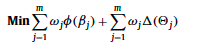

In [38]:
all_possible_patient_schedules

[{'patient': 'p1',
  'bed': 'b1',
  'possible_allocated_schedule': {1: {900: 0,
    1000: 0,
    1100: 0,
    1400: 0,
    1500: 0,
    1600: 0,
    1700: 0},
   2: {1700: 0, 1800: 0, 1900: 0},
   3: {1900: 0, 2000: 0, 2100: 0},
   4: {800: 0, 900: 0, 1000: 0},
   6: {900: 0, 1000: 0, 1100: 0}}},
 {'patient': 'p1',
  'bed': 'b2',
  'possible_allocated_schedule': {1: {900: 0,
    1000: 0,
    1100: 0,
    1400: 0,
    1500: 0,
    1600: 0,
    1700: 0},
   2: {1700: 0, 1800: 0, 1900: 0},
   3: {1900: 0, 2000: 0, 2100: 0},
   4: {800: 0, 900: 0, 1000: 0},
   6: {900: 0, 1000: 0, 1100: 0}}},
 {'patient': 'p2',
  'bed': 'b1',
  'possible_allocated_schedule': {1: {1000: 0, 1100: 0, 1200: 0, 1300: 0},
   2: {1000: 0, 1100: 0, 1200: 0, 1300: 0, 1700: 0, 1800: 0, 1900: 0},
   4: {1200: 0, 1300: 0, 1400: 0, 1600: 0, 1700: 0, 1800: 0, 1900: 0},
   6: {800: 0, 900: 0, 1000: 0}}},
 {'patient': 'p2',
  'bed': 'b2',
  'possible_allocated_schedule': {1: {1000: 0, 1100: 0, 1200: 0, 1300: 0},
   2: {10

Set some initial variables

In [39]:
patient_counter = 0
patient_schedules_in_list = []
patient_schedules_out_list = []

In [40]:
multi_appt_assigned_days = {}

#### 4ai. Reserve beds for patients on a first come first serve basis

In [41]:
patient_schedules_out_list, patient_schedules_in_list = reserve_patient_beds(all_possible_patient_schedules, patient_schedules_in_list, patient_schedules_out_list, bed_objects_list)

print("this is the patient_schedules_out_list", patient_schedules_out_list)
print("this is the patient_schedules_in_list", patient_schedules_in_list)

this is the patient_schedules_out_list [{'patient': 'p2', 'bed': 'b1', 'day': 1, 'schedule': {1000: 0, 1100: 0, 1200: 0, 1300: 0}}, {'patient': 'p2', 'bed': 'b1', 'day': 2, 'schedule': {1000: 0, 1100: 0, 1200: 0, 1300: 0, 1700: 0, 1800: 0, 1900: 0}}, {'patient': 'p2', 'bed': 'b1', 'day': 6, 'schedule': {800: 0, 900: 0, 1000: 0}}, {'patient': 'p2', 'bed': 'b2', 'day': 1, 'schedule': {1000: 0, 1100: 0, 1200: 0, 1300: 0}}, {'patient': 'p2', 'bed': 'b2', 'day': 2, 'schedule': {1000: 0, 1100: 0, 1200: 0, 1300: 0, 1700: 0, 1800: 0, 1900: 0}}, {'patient': 'p2', 'bed': 'b2', 'day': 6, 'schedule': {800: 0, 900: 0, 1000: 0}}, {'patient': 'p3', 'bed': 'b1', 'day': 4, 'schedule': {1600: 0, 1700: 0, 1800: 0}}, {'patient': 'p3', 'bed': 'b2', 'day': 4, 'schedule': {1600: 0, 1700: 0, 1800: 0}}, {'patient': 'p4', 'bed': 'b1', 'day': 1, 'schedule': {900: 0, 1000: 0, 1100: 0, 1200: 0}}, {'patient': 'p4', 'bed': 'b1', 'day': 2, 'schedule': {1100: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0}}, {'patient': 'p4', 

#### 4aii. Check the spacing between the times in terms of how far apart they are regardless if they are occupying another bed

In [42]:
patient_schedules_out_list, patient_schedules_in_list, multi_appt_assigned_days = check_time_spacing(patient_schedules_out_list, patient_schedules_in_list, bed_objects_list)

print("patient_schedule_out_list:", patient_schedules_out_list)
print("patient_schedule_in_list:", patient_schedules_in_list)

patient_schedule_out_list: [{'patient': 'p2', 'bed': 'b1', 'day': 1, 'schedule': {1000: 0, 1100: 0, 1200: 0, 1300: 0}}, {'patient': 'p2', 'bed': 'b1', 'day': 2, 'schedule': {1000: 0, 1100: 0, 1200: 0, 1300: 0, 1700: 0, 1800: 0, 1900: 0}}, {'patient': 'p2', 'bed': 'b1', 'day': 6, 'schedule': {800: 0, 900: 0, 1000: 0}}, {'patient': 'p2', 'bed': 'b2', 'day': 1, 'schedule': {1000: 0, 1100: 0, 1200: 0, 1300: 0}}, {'patient': 'p2', 'bed': 'b2', 'day': 2, 'schedule': {1000: 0, 1100: 0, 1200: 0, 1300: 0, 1700: 0, 1800: 0, 1900: 0}}, {'patient': 'p2', 'bed': 'b2', 'day': 6, 'schedule': {800: 0, 900: 0, 1000: 0}}, {'patient': 'p3', 'bed': 'b1', 'day': 4, 'schedule': {1600: 0, 1700: 0, 1800: 0}}, {'patient': 'p3', 'bed': 'b2', 'day': 4, 'schedule': {1600: 0, 1700: 0, 1800: 0}}, {'patient': 'p4', 'bed': 'b1', 'day': 1, 'schedule': {900: 0, 1000: 0, 1100: 0, 1200: 0}}, {'patient': 'p4', 'bed': 'b1', 'day': 2, 'schedule': {1100: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0}}, {'patient': 'p4', 'bed': 'b2',

#### 4aiii. Remove non-consecutive schedules

In [43]:
patient_schedules_in_list = remove_non_consecutive_schedules(patient_schedules_out_list, patient_schedules_in_list)

In [44]:
# Print the modified schedule list
for entry in patient_schedules_in_list:
    print(entry)

{'patient': 'p1', 'bed': 'b1', 'day': 1, 'schedule': {900: 0, 1000: 0, 1100: 0}}
{'patient': 'p1', 'bed': 'b1', 'day': 3, 'schedule': {1900: 0, 2000: 0, 2100: 0}}
{'patient': 'p1', 'bed': 'b1', 'day': 6, 'schedule': {900: 0, 1000: 0, 1100: 0}}
{'patient': 'p1', 'bed': 'b2', 'day': 1, 'schedule': {900: 0, 1000: 0, 1100: 0}}
{'patient': 'p1', 'bed': 'b2', 'day': 3, 'schedule': {1900: 0, 2000: 0, 2100: 0}}
{'patient': 'p1', 'bed': 'b2', 'day': 6, 'schedule': {900: 0, 1000: 0, 1100: 0}}
{'patient': 'p2', 'bed': 'b1', 'day': 4, 'schedule': {1200: 0, 1300: 0, 1400: 0}}
{'patient': 'p2', 'bed': 'b2', 'day': 4, 'schedule': {1200: 0, 1300: 0, 1400: 0}}
{'patient': 'p3', 'bed': 'b1', 'day': 1, 'schedule': {2000: 0, 2100: 0, 2200: 0}}
{'patient': 'p3', 'bed': 'b1', 'day': 5, 'schedule': {1000: 0, 1100: 0, 1200: 0}}
{'patient': 'p3', 'bed': 'b2', 'day': 1, 'schedule': {2000: 0, 2100: 0, 2200: 0}}
{'patient': 'p3', 'bed': 'b2', 'day': 5, 'schedule': {1000: 0, 1100: 0, 1200: 0}}
{'patient': 'p4', 'b

#### 4aiv. Check that patient does not already occupy another bed!

In [45]:
patient_schedules_out_list, patient_schedules_in_list = remove_occupied_beds(patient_schedules_out_list, patient_schedules_in_list, bed_objects_list, multi_appt_assigned_days)

In [46]:
print("patient_schedule_out_list:", patient_schedules_out_list)
print("patient_schedule_in_list:", patient_schedules_in_list)

patient_schedule_out_list: [{'patient': 'p2', 'bed': 'b1', 'day': 1, 'schedule': {1000: 0, 1100: 0, 1200: 0, 1300: 0}}, {'patient': 'p2', 'bed': 'b1', 'day': 2, 'schedule': {1000: 0, 1100: 0, 1200: 0, 1300: 0, 1700: 0, 1800: 0, 1900: 0}}, {'patient': 'p2', 'bed': 'b1', 'day': 6, 'schedule': {800: 0, 900: 0, 1000: 0}}, {'patient': 'p2', 'bed': 'b2', 'day': 1, 'schedule': {1000: 0, 1100: 0, 1200: 0, 1300: 0}}, {'patient': 'p2', 'bed': 'b2', 'day': 2, 'schedule': {1000: 0, 1100: 0, 1200: 0, 1300: 0, 1700: 0, 1800: 0, 1900: 0}}, {'patient': 'p2', 'bed': 'b2', 'day': 6, 'schedule': {800: 0, 900: 0, 1000: 0}}, {'patient': 'p3', 'bed': 'b1', 'day': 4, 'schedule': {1600: 0, 1700: 0, 1800: 0}}, {'patient': 'p3', 'bed': 'b2', 'day': 4, 'schedule': {1600: 0, 1700: 0, 1800: 0}}, {'patient': 'p4', 'bed': 'b1', 'day': 1, 'schedule': {900: 0, 1000: 0, 1100: 0, 1200: 0}}, {'patient': 'p4', 'bed': 'b1', 'day': 2, 'schedule': {1100: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0}}, {'patient': 'p4', 'bed': 'b2',

In [47]:
for i in patient_schedules_in_list:
    print(i)

{'patient': 'p1', 'bed': 'b1', 'day': 6, 'schedule': {900: 0, 1000: 0, 1100: 0}}
{'patient': 'p1', 'bed': 'b2', 'day': 1, 'schedule': {900: 0, 1000: 0, 1100: 0}}
{'patient': 'p1', 'bed': 'b2', 'day': 3, 'schedule': {1900: 0, 2000: 0, 2100: 0}}
{'patient': 'p2', 'bed': 'b1', 'day': 4, 'schedule': {1200: 0, 1300: 0, 1400: 0}}
{'patient': 'p3', 'bed': 'b2', 'day': 1, 'schedule': {2000: 0, 2100: 0, 2200: 0}}
{'patient': 'p3', 'bed': 'b2', 'day': 5, 'schedule': {1000: 0, 1100: 0, 1200: 0}}
{'patient': 'p4', 'bed': 'b1', 'day': 3, 'schedule': {1300: 0, 1400: 0, 1500: 0, 1600: 0}}
{'patient': 'p4', 'bed': 'b1', 'day': 5, 'schedule': {1800: 0, 1900: 0, 2000: 0}}
{'patient': 'p6', 'bed': 'b1', 'day': 4, 'schedule': {1600: 0, 1700: 0, 1800: 0}}
{'patient': 'p7', 'bed': 'b1', 'day': 5, 'schedule': {1300: 0, 1400: 0, 1500: 0}}


In [48]:
check_occupied_beds(patient_schedules_in_list, bed_objects_list)

THIS IS THE BED_ID b1
Bed b1 Day 6 Time Slot 900 Assigned to p1
Bed b1 Day 6 Time Slot 1000 Assigned to p1
Bed b1 Day 6 Time Slot 1100 Assigned to p1
THIS IS THE BED_ID b1
THIS IS THE BED_ID b1
THIS IS THE BED_ID b1
Bed b1 Day 4 Time Slot 1200 Assigned to p2
Bed b1 Day 4 Time Slot 1300 Assigned to p2
Bed b1 Day 4 Time Slot 1400 Occupied by p2
THIS IS THE BED_ID b1
THIS IS THE BED_ID b1
THIS IS THE BED_ID b1
Bed b1 Day 3 Time Slot 1300 Occupied by p4
Bed b1 Day 3 Time Slot 1400 Occupied by p4
Bed b1 Day 3 Time Slot 1500 Occupied by p4
Bed b1 Day 3 Time Slot 1600 Occupied by p4
THIS IS THE BED_ID b1
Bed b1 Day 5 Time Slot 1800 Assigned to p4
Bed b1 Day 5 Time Slot 1900 Assigned to p4
Bed b1 Day 5 Time Slot 2000 Assigned to p4
THIS IS THE BED_ID b1
Bed b1 Day 4 Time Slot 1600 Occupied by p6
Bed b1 Day 4 Time Slot 1700 Occupied by p6
Bed b1 Day 4 Time Slot 1800 Assigned to p6
THIS IS THE BED_ID b1
Bed b1 Day 5 Time Slot 1300 Assigned to p7
Bed b1 Day 5 Time Slot 1400 Occupied by p7
Bed b1 

In [49]:
for bed in bed_objects_list:
    print(bed.bed_id)
    for day in bed.bed_schedule: 
        print(day, bed.bed_schedule[day])

b1
1 {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 'p1', 1800: 0, 1900: 0, 2000: 0, 2100: 0, 2200: 0}
2 {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0, 2100: 0, 2200: 0}
3 {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 'p4', 1400: 'p4', 1500: 'p4', 1600: 'p4', 1700: 0, 1800: 0, 1900: 0, 2000: 0, 2100: 0, 2200: 0}
4 {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 'p2', 1300: 'p2', 1400: 'p2', 1500: 0, 1600: 'p6', 1700: 'p6', 1800: 'p6', 1900: 0, 2000: 0, 2100: 0, 2200: 0}
5 {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 'p7', 1400: 'p7', 1500: 'p7', 1600: 0, 1700: 0, 1800: 'p4', 1900: 'p4', 2000: 'p4', 2100: 0, 2200: 0}
6 {800: 0, 900: 'p1', 1000: 'p1', 1100: 'p1', 1200: 0, 1300: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0, 2100: 0, 2200: 0}
b2
1 {800: 0, 900: 'p1', 1000: 'p1', 1100: 'p1', 1200: 0, 1300: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 'p1', 1800: 0, 1900: 

## 5. FCFS Class

### 5a. Initialize the FCFS Schedule Object

In [50]:
patient_schedules_in = patient_schedules_in_list
patient_schedules_out = patient_schedules_out_list
objective = 0
contribution = 0
penalty = 0

In [51]:
new_final_FCFS_schedule = FCFS_confirmed_schedule(patient_schedules_in, patient_schedules_out, objective, contribution, penalty)

In [52]:
# TODO Create function from this
# Get the schedule of the patient and assign to the new final FCFS schedule
for obj in patient_objects_list:
    schedule_list = []
    for patient_sched in patient_schedules_in:
        if obj.patient_id == patient_sched['patient']:
            schedule_entry = {}
            schedule_entry['bed'] = patient_sched['bed']
            schedule_entry['day'] = patient_sched['day']
            schedule_entry['schedule'] = patient_sched['schedule']
            schedule_list.append(schedule_entry)
            obj.confirmed_schedule = schedule_list

### 5b. Calculate the Leftover appointment

Functions: count_leftover_appointments, count_penalty, and count_total_confirmed_hours also are in calculate values for the objective function

In [53]:
# calculate leftover appointments
for obj in patient_objects_list:
    obj.leftover = num_required_dialysis_sessions - obj.calculate_schedule_length()

### 5c. Objective Function and Constraints

Let **J = { 1 , . . . , m } be the set of $m$ patients** to be allocated to a **set of $n$ identical beds I = { 1 , . . . , n }** over a six-day working week, where each day is 14-hour long. Each patient j ∈ Jis prescribed a total of $t_j$ hours of dialysis per week (split into ηequally-long dialysis appointments, usually η= 3 ). 
$p_j$ = Each dialysis appointment of a patient j ∈ J, therefore, has a processing time $p_j$ which includes the pa- tient’s check-in time, put-on time on a dialysis machine (a technician puts the patient on a bed (or a chair), and connects them to the dialysis machine), dialysis time on the dialysis machine, and take-offtime (a technician takes thepatient offthebed, discon- nects them from the dialysis machine and cleans the bed).

**Main objective**: Therefore, our main objective is to maximize the number of appointments that are scheduled according to patients’ availability (with a minimum of $\delta$ slots deviation from their ideal time slots). Equivalently, we penalize the failure to assign any number of the required $\nu$ appointments for each patient (i.e., leftover ap-
pointments) as well as the total deviations in the patient’s weekly schedule.

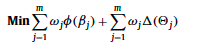

**Objective** : minimize the total leftover appointments penalty, which is calculated as the equation below where $w_j$ is a pre-specified weight computed based on the severity of the patient’s health condition

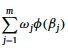

**Explanation of terms below:**

$\theta_j$ $\subseteq$ $S$ be the set of all time slots that patient j's dialysis appointments are allocated to

$\beta_j$ = total number of leftover appointments in schedule $\theta_j$ of patient $j$

 is total number of leftover appointments in schedule $\theta_j$ of patient j 

$\phi$ $(\beta_j)$ = penalty associated with $\theta$ with $\phi$(0) = 0 and $\phi$(1) $\geq \eta * m * \delta$ , and we assume $\phi$(3) $\gg$ $\phi$(2) $\gg$ $\phi$(1) where the highest priority is to minimize the number of patients with 3 leftover appointments.

$\eta$ = number of required dialysis sessions of patients,
$m$ = number of patients,
$\delta$ = allowed deviation limit from patients' target slots

Each patient j ∈ J is prescribed a total of $t_j$ hours of dialysis per week (split into $\eta$ equally-long dialysis appointments, usually $\eta$ = 3 ) based on page 37 of Reihnahe et al.

calculate_value.py contains various functions used for calculating the objective function

In [54]:
obj_function = 0
total_confirmed_timeslots = 0
total_count_one = 0
total_count_two = 0
total_count_three = 0
total_count_zero = 0
total_count_dialysis_hours = 0

for obj in patient_objects_list:
    obj_function_inc, num_confirmed_timeslots, count_one, count_two, count_three, count_zero, confirmed_total_dialysis_hours =  calculate_objective_function(obj.patient_id, obj.confirmed_schedule, obj.weight, obj.leftover, obj.prescribed_total_dialysis_hours, num_required_dialysis_sessions, num_patients, max_allowed_deviation)
    obj_function += obj_function_inc
    total_confirmed_timeslots += num_confirmed_timeslots
    total_count_one += count_one
    total_count_two += count_two
    total_count_three += count_three
    total_count_zero += count_zero
    total_count_dialysis_hours += confirmed_total_dialysis_hours

In [55]:
obj_function

2532877.0

In [56]:
total_confirmed_timeslots

10

In [57]:
total_count_one

3

In [58]:
total_count_two

2

In [59]:
total_count_three

1

In [60]:
total_count_zero

2

In [61]:
total_count_dialysis_hours

31

In [62]:
prescribed_total_dialysis_hours_all_patients = sum(prescribed_dialysis_hours_list)
prescribed_total_dialysis_hours_all_patients

87

## 6. Getting the results of FCFS

Dialysis treatment times are 4 hours to comply with the average reported length of hemodialysis treatment , but it is usually between 3 to 5 hours. So lets find a time when both patients and beds are free at the same time and store it in a dictionary

### 6a. RUN ONLY IF RUNNING FOR THE FIRST TIME, OTHERWISE COMMENT IT OUT

In [95]:
 FCFS_df = []

FCFS_df = pd.DataFrame({str(0): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]},index = [initial_rows])

In [96]:
initial_rows = [
    "Number of beds",
    "Number of patients",
    "Max allowed deivation",
    "Objective function",
    "Total confirmed slots",
    "Total confirmed hours",
    "Percentage leftover slots out of prescribed",
    "Percentage confirmed hours out of prescribed",
    "Count 0",
    "Count 1",
    "Count 2",
    "Count 3"
]

### 6b. RUN THE FOLLOWING CODE FREELY TO POPULATE THE DATAFRAME

In [97]:
title_rows_bed = str(num_beds) + '-' + str(num_patients) + '-' + str(max_allowed_deviation)

In [98]:
percentage_slots_leftover = 1 - (total_confirmed_timeslots / (num_patients * num_required_dialysis_sessions))
percentage_hours = (total_count_dialysis_hours / prescribed_total_dialysis_hours_all_patients)

In [99]:
# If the number of bedds equals to zero then this the dataframe still has the initial values
if FCFS_df.iloc[:,0]['Number of beds'] == 0:
    FCFS_df = FCFS_df.rename(columns={'0':title_rows_bed})
    
    FCFS_df.iloc[0, 0] = num_beds
    FCFS_df.iloc[1, 0] = num_patients
    FCFS_df.iloc[2, 0] = max_allowed_deviation
    FCFS_df.iloc[3, 0] = obj_function
    FCFS_df.iloc[4, 0] = total_confirmed_timeslots
    FCFS_df.iloc[5, 0] = total_count_dialysis_hours
    FCFS_df.iloc[6, 0] = percentage_slots_leftover
    FCFS_df.iloc[7, 0] = percentage_hours
    FCFS_df.iloc[8, 0] = total_count_zero
    FCFS_df.iloc[9, 0] = total_count_one
    FCFS_df.iloc[10, 0] = total_count_two
    FCFS_df.iloc[11, 0] = total_count_three
else:
    FCFS_df[title_rows_bed] = [num_beds, num_patients, max_allowed_deviation, obj_function, total_confirmed_timeslots, total_count_dialysis_hours, 
                               percentage_slots_leftover, percentage_hours, total_count_zero, total_count_one, total_count_two, total_count_three ]


In [100]:
FCFS_df[title_rows_bed] = [num_beds, num_patients, max_allowed_deviation, obj_function, total_confirmed_timeslots, total_count_dialysis_hours, 
                               percentage_slots_leftover, percentage_hours, total_count_zero, total_count_one, total_count_two, total_count_three ]


In [101]:
FCFS_df

,2-8-4
Number of beds,2.000000e+00
Number of patients,8.000000e+00
Max allowed deivation,4.000000e+00
Objective function,2.532877e+06
Total confirmed slots,1.000000e+01
Total confirmed hours,3.100000e+01
Percentage leftover slots out of prescribed,5.833333e-01
Percentage confirmed hours out of prescribed,3.563218e-01
Count 0,2.000000e+00
Count 1,3.000000e+00


### 6c. After you run the file to include all combinations of n,m,δ which is ['10-40-1',	'15-60-1',	'20-80-1',	'10-40-2',	'15-60-2',	'20-80-2',	'10-40-4',	'15-60-4',	'20-80-4'] then run the below to make the graphs

#### 6ci. Save the FCFS_df dataframe with all the results of the FCFS approaach to a CSV file

In [102]:
# Define the date to add to the end of the CSV file
now = datetime.now()
dt_string = now.strftime("%Y%m%d%H%M%S")

file_name = 'results_FCFS'+dt_string+'.csv'

FCFS_df.to_csv('results/'+file_name, sep=',', encoding='utf-8')

### 6d. Create some graphs

#### 6di. Define values to create the catplot

In [110]:
obj_function_values = FCFS_df.iloc[3].tolist()
obj_function_values

[2532877.0]

In [111]:
bars_count = ['count 0', 'count 1', 'count 2', 'count 3']
bars_graph = []

for i in range(len(combi_patient_bed_deviation)):
    bars_graph.extend(bars_count)

In [116]:
len(bars_graph)

36

In [112]:
combi_patient_bed_deviation = ['10-40-1',	'15-60-1',	'20-80-1',	'10-40-2',	'15-60-2',	'20-80-2',	'10-40-4',	'15-60-4',	'20-80-4']


In [129]:
combi_graph = []
for combi in combi_patient_bed_deviation:
    for bars in range(len(bars_count)):
        combi_graph.append(combi)
        
combi_graph.sort()

In [130]:
len(combi_graph)

36

In [131]:
count_values = []

for column in range(0, len(FCFS_df.columns)):
    for row in range(8, len(FCFS_df)):
        print(FCFS_df.iloc[row, column])
        count_values.append(FCFS_df.iloc[row, column])


2.0
3.0
2.0
1.0


In [132]:
len(count_values)

4

#### 6dii. Draw the Catplot

In [133]:


df = pd.DataFrame({'(n,m,δ)': combi_graph,
                   'bar': bars_graph,
                   'value': count_values})
g = sns.catplot(kind='bar', data=df, col='(n,m,δ)', x='bar', y='value',
                hue='bar', palette='viridis', dodge=False, sharex=False, aspect=0.6, legend=False)


# Set overall title for the entire catplot
plt.subplots_adjust(top=0.85)  # Adjust the top space for the title
g.fig.suptitle("Distribution of Appointments in FCFS Approach - Patient-to-Bed Ratio r = 4", fontsize=16)  # Set the main title


# Change y-axis title*
g.set_axis_labels("", "Count of confirmed slots")  # Replace with your desired labels

# Get the current axes
axes = g.axes.flatten()

# Create a single legend outside the loop
handles, labels = axes[0].get_legend_handles_labels()
g.fig.legend(handles, labels, loc='mid right')  # Adjust the loc parameter

g.fig.legend.remove()

# Set the font size of xticks
plt.xticks(fontsize=25)
plt.tight_layout()
plt.show()

ValueError: All arrays must be of the same length

#### 6dii. Draw a liine graph

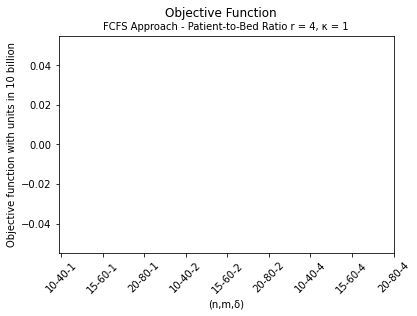

In [109]:
# Create the line chart
plt.plot(obj_function_values)

# Set x-axis labels
plt.xticks(range(len(combi_patient_bed_deviation)), combi_patient_bed_deviation, rotation=45)  # Set x-axis labels with positions and labels

# Set y-axis label
plt.ylabel("Objective function with units in 10 billion")
plt.xlabel("(n,m,δ)")

# Set title
plt.suptitle("Objective Function", fontsize = 12)
plt.title("FCFS Approach - Patient-to-Bed Ratio r = 4, κ = 1", fontsize = 10)

# Show the plot
plt.show()

## 7. Multi-Appointment Scheduling to Confirm Schedules

### 7a. Initial Setup

#### 7ai. Reset the patient and bed list of objects

In [75]:
for patient in SA_patient_objects_list:
    patient.processing_time = 0
    patient.confirmed_schedule = {}
    patient.leftover = 0
    print(patient.patient_id)
    print(patient.confirmed_schedule)
    print(patient.ideal_schedule)

p1
{}
{1: {800: 1, 900: 0, 1000: 0, 1100: 0, 1200: 1, 1300: 1, 1400: 0, 1500: 0, 1600: 0, 1700: 0, 1800: 1, 1900: 0, 2000: 1, 2100: 1, 2200: 0}, 2: {800: 1, 900: 1, 1000: 0, 1100: 1, 1200: 0, 1300: 1, 1400: 0, 1500: 0, 1600: 1, 1700: 0, 1800: 0, 1900: 0, 2000: 1, 2100: 0, 2200: 1}, 3: {800: 1, 900: 1, 1000: 1, 1100: 0, 1200: 1, 1300: 1, 1400: 0, 1500: 1, 1600: 0, 1700: 1, 1800: 1, 1900: 0, 2000: 0, 2100: 0, 2200: 1}, 4: {800: 0, 900: 0, 1000: 0, 1100: 1, 1200: 1, 1300: 0, 1400: 0, 1500: 1, 1600: 1, 1700: 1, 1800: 1, 1900: 1, 2000: 1, 2100: 0, 2200: 1}, 5: {800: 0, 900: 0, 1000: 1, 1100: 0, 1200: 1, 1300: 1, 1400: 1, 1500: 1, 1600: 1, 1700: 0, 1800: 1, 1900: 1, 2000: 0, 2100: 1, 2200: 1}, 6: {800: 1, 900: 0, 1000: 0, 1100: 0, 1200: 1, 1300: 1, 1400: 1, 1500: 1, 1600: 1, 1700: 1, 1800: 1, 1900: 0, 2000: 1, 2100: 0, 2200: 1}}
p2
{}
{1: {800: 1, 900: 1, 1000: 0, 1100: 0, 1200: 0, 1300: 0, 1400: 1, 1500: 0, 1600: 1, 1700: 0, 1800: 0, 1900: 1, 2000: 1, 2100: 1, 2200: 1}, 2: {800: 1, 900: 1, 

In [76]:
SA_bed_objects_list = []

for item in all_beds_availablity_list:
    bed_id = item['bed']
    bed_schedule = item['bed_availability']
    print(bed_id)
    print(bed_schedule)
    SA_bed_objects_list.append(Bed(bed_id, bed_schedule))

b1
{1: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 'p1', 1800: 0, 1900: 0, 2000: 0, 2100: 0, 2200: 0}, 2: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0, 2100: 0, 2200: 0}, 3: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 'p4', 1400: 'p4', 1500: 'p4', 1600: 'p4', 1700: 0, 1800: 0, 1900: 0, 2000: 0, 2100: 0, 2200: 0}, 4: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 'p2', 1300: 'p2', 1400: 'p2', 1500: 0, 1600: 'p6', 1700: 'p6', 1800: 'p6', 1900: 0, 2000: 0, 2100: 0, 2200: 0}, 5: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 'p7', 1400: 'p7', 1500: 'p7', 1600: 0, 1700: 0, 1800: 'p4', 1900: 'p4', 2000: 'p4', 2100: 0, 2200: 0}, 6: {800: 0, 900: 'p1', 1000: 'p1', 1100: 'p1', 1200: 0, 1300: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0, 2100: 0, 2200: 0}}
b2
{1: {800: 0, 900: 'p1', 1000: 'p1', 1100: 'p1', 1200: 0, 1300: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 'p1', 

In [77]:
# start with the initial schedule of poassible allocated time slots
# make a copy of27 the initial schedule and call it unvisited
SA_all_possible_patient_schedules = all_possible_patient_schedules.copy()

In [78]:
SA_all_possible_patient_schedules

[{'patient': 'p1',
  'bed': 'b1',
  'possible_allocated_schedule': {1: {900: 0,
    1000: 0,
    1100: 0,
    1400: 0,
    1500: 0,
    1600: 0,
    1700: 0},
   2: {1700: 0, 1800: 0, 1900: 0},
   3: {1900: 0, 2000: 0, 2100: 0},
   4: {800: 0, 900: 0, 1000: 0},
   6: {900: 0, 1000: 0, 1100: 0}}},
 {'patient': 'p1',
  'bed': 'b2',
  'possible_allocated_schedule': {1: {900: 0,
    1000: 0,
    1100: 0,
    1400: 0,
    1500: 0,
    1600: 0,
    1700: 0},
   2: {1700: 0, 1800: 0, 1900: 0},
   3: {1900: 0, 2000: 0, 2100: 0},
   4: {800: 0, 900: 0, 1000: 0},
   6: {900: 0, 1000: 0, 1100: 0}}},
 {'patient': 'p2',
  'bed': 'b1',
  'possible_allocated_schedule': {1: {1000: 0, 1100: 0, 1200: 0, 1300: 0},
   2: {1000: 0, 1100: 0, 1200: 0, 1300: 0, 1700: 0, 1800: 0, 1900: 0},
   4: {1200: 0, 1300: 0, 1400: 0, 1600: 0, 1700: 0, 1800: 0, 1900: 0},
   6: {800: 0, 900: 0, 1000: 0}}},
 {'patient': 'p2',
  'bed': 'b2',
  'possible_allocated_schedule': {1: {1000: 0, 1100: 0, 1200: 0, 1300: 0},
   2: {10

### 7b. Find neighbor function

In [79]:

def calculate_solution_obj_function(schedule):
    # Your scoring logic here
    # Calculate a score based on the quality of the schedule
    # Higher scores are better
    new_final_FCFS_schedule = FCFS_confirmed_schedule(patient_schedules_in, patient_schedules_out, objective, contribution, penalty)
    
    # TODO Create function from this
    # Get the schedule of the patient and assign to the new final FCFS schedule
    for obj in patient_objects_list:
        schedule_list = []
        for patient_sched in patient_schedules_in:
            if obj.patient_id == patient_sched['patient']:
                schedule_entry = {}
                schedule_entry['bed'] = patient_sched['bed']
                schedule_entry['day'] = patient_sched['day']
                schedule_entry['schedule'] = patient_sched['schedule']
                schedule_list.append(schedule_entry)
                obj.confirmed_schedule = schedule_list

    obj.leftover = num_required_dialysis_sessions - obj.calculate_schedule_length()

    obj_function = 0
    total_confirmed_timeslots = 0
    total_count_one = 0
    total_count_two = 0
    total_count_three = 0
    total_count_zero = 0

    for obj in patient_objects_list:
        obj_function_inc, num_confirmed_timeslots, count_one, count_two, count_three, count_zero, confirmed_total_dialysis_hours =  calculate_objective_function(obj.patient_id, obj.confirmed_schedule, obj.weight, obj.leftover, 
                                                                                                                                 obj.prescribed_total_dialysis_hours, num_required_dialysis_sessions, 
                                                                                                                                 num_patients, max_allowed_deviation)

        obj_function += obj_function_inc
        total_confirmed_timeslots += num_confirmed_timeslots
        total_count_one += count_one
        total_count_two += count_two
        total_count_three += count_three
        total_count_zero += count_zero
    return obj_function

In [80]:
def generate_neighbor_solution(current_schedule):
    in_list = []
    out_list = []
    neighbor_schedule = []

    for patient_info in current_schedule:
        patient = patient_info['patient']
        bed = patient_info['bed']
        possible_schedule = patient_info['possible_allocated_schedule']

        new_schedule = {}
        for day, slots in possible_schedule.items():
            available_slots = list(slots.keys())
            selected_slots = random.sample(available_slots, 3)  # Select 3 random time slots

            # Sort the selected slots and find consecutive slots
            selected_slots.sort()
            consecutive_slots = []
            for i in range(len(selected_slots) - 2):
                if selected_slots[i + 1] == selected_slots[i] + 100 and selected_slots[i + 2] == selected_slots[i] + 200:
                    consecutive_slots = selected_slots[i:i + 3]
                    break

            new_slots = {slot: slots[slot] for slot in consecutive_slots}
            new_schedule[day] = new_slots

        neighbor_solution = {
            'patient': patient,
            'bed': bed,
            'possible_allocated_schedule': new_schedule
        }
        
        if neighbor_solution == patient_info:
            in_list.append(neighbor_solution)
        else:
            out_list.append(neighbor_solution)
            
        neighbor_schedule.append(neighbor_solution)

    return neighbor_schedule, out_list


In [81]:
def find_neighbor(current_schedule):
    neighbor_schedule = current_schedule.copy()
    reordered_patient_object_list = reorder_list(patient_objects_list)
    
    # reserve patient beds by the order of the patients and their weights
    multiappt_patient_schedules_out_list, multiappt_patient_schedules_in_list = reserve_patient_beds_by_weight(SA_all_possible_patient_schedules, reordered_patient_object_list, bed_objects_list, patient_schedules_in_list, patient_schedules_out_list)
    # check the time spacing and make sure that they are at least one day apart
    random.shuffle(multiappt_patient_schedules_out_list)
    random.shuffle(multiappt_patient_schedules_in_list)
    multiappt_patient_schedules_out_list, multiappt_patient_schedules_in_list, multi_apptassigned_days = check_time_spacing(multiappt_patient_schedules_out_list, multiappt_patient_schedules_in_list, bed_objects_list)
    # remove any schedules that are not consecutive
    random.shuffle(multiappt_patient_schedules_out_list)
    random.shuffle(multiappt_patient_schedules_in_list)
    multiappt_patient_schedules_in_list = remove_non_consecutive_schedules(multiappt_patient_schedules_out_list, multiappt_patient_schedules_in_list)
    # remove any cases when beds are occupied by the same patient
    random.shuffle(multiappt_patient_schedules_out_list)
    random.shuffle(multiappt_patient_schedules_in_list)
    multiappt_patient_schedules_out_list, multiappt_patient_schedules_in_list = remove_occupied_beds(multiappt_patient_schedules_out_list, multiappt_patient_schedules_in_list, bed_objects_list, multi_appt_assigned_days)
    
    print("this is the current schedule")
    print(current_schedule)
    
    return multiappt_patient_schedules_out_list, multiappt_patient_schedules_in_list

### 7c. Initialize the Multi-Appointment Schedule Object

In [82]:
# make it that the appointment is as long as possible, if possible 5 hours, if not then 3
# GOAL: update schedule for the bed now, because now they are being taken by a particular patient, insert the name of the patient
# GOAL: create then a single patient appointment schedule

In [83]:
class Multi_appt_confirmed_schedule:
    def __init__(self, patient_schedules_in, patient_schedules_out, objective, contribution, penalty):
        # patient schedules that work out are stored inside
        self.patient_schedules_in = patient_schedules_in
        # patient schedules that did not work out get stored outside
        self.patient_schedules_out = patient_schedules_out
        # objective function value to minimize
        self.objective = objective
        # contribution of a_j to the value of the objective function 
        self.contribution = contribution
        # dual value associated with Constraint 2c TODO: IS THIS NEEDED? Constraint (2c) 
        # restricts the number of available beds to n .
        # self.lambda_dual = lambda_dual
        # penalty
        self.penalty = penalty 
    
    
    ## NOT NEEDED?
    def copy_multi_appt_confirmed_schedule(self, patient_schedules_in, patient_schedules_out, objective, contribution, penalty):
        new_multi_appt_confirmed_schedule = Multi_appt_confirmed_schedule(patient_schedules_in, patient_schedules_out, objective, contribution, penalty)
        new_patient_id = copy.deepcopy(patient_id)
        new_patient_schedules_in = copy.deepcopy(self.patient_schedules_in)
        new_patient_schedules_out = copy.deepcopy(self.patient_schedules_out)
        new_allocation_objective = self.objective
        new_allocation_contribution = self.contribution
        # new_lambda_dual = self.lambda_dual
        new_penalty = self.penalty
        return new_multi_appt_confirmed_schedule
    
    ## NOT NEEDED?
    def add_time_slot(self, time_slot):
        """
        add possible time slot to the schedule
        """
        # update to the schedules
        self.patient_schedules_in.add(time_slot)
        self.patient_schedules_out.remove(time_slot)
        
    
    ## NOT NEEDED?
    def remove_time_slot(self, time_slot):
        """
        remove time slot from the schedule
        """
        # add the item to the knapsack and update the capacity left, objective and sets
        self.patient_schedules_in.remove(time_slot)
        self.patient_schedules_out.add(time_slot)
    
    ## NOT NEEDED?
    def set_binary_z_0(self, binary_z):
        """
        set binary_z to 0 if it schedule is NOT according to a_j
        """
        self.binary_z = 0
    
    ## NOT NEEDED?
    def set_binary_z_1(self, binary_z):
        """
        set binary_z to 1 if schedule is according to a_j
        """
        self.binary_z = 1
    
    ## NOT NEEDED?
    def make_feasible(self, time_slot):
        """
        remove time slot that is not feasible
        """
        if check_if_feasible == False:
            self.FCFS_confirmed_schedule.remove_time_slot(time_slot)
        
    ## NOT NEEDED?
    def check_bed_availablily(self):
        """
        if it is feasible with the schedule of the patients
        """
        # another patient does not currently stay there
        
    ## NOT NEEDED?
    def find_neighbour(self):
        """
        neighbor = reorganizing the patients to fit the schedule
        """
        
        # Given the current schedule that you have of the patient and bed assignments, is there a way to try more combinations
        patients = set()
        sum = 0
        for i in self.patient_schedule_out:
            candidates.add((i, sum, sum + items[i].value))
            sum += items[i].value

        chosen_prob = random.uniform(0, sum)
        for j in candidates:
            if chosen_prob > j[1] and chosen_prob <= j[2]:
                chosen_item = j[0]

        #chosen_item = random.sample(self.items_out, 1)[0]
        neighbour = self.copy_FCFS_confirmed_schedule()
        neighbour.add_time_slot(chosen_item)  # try to add a random item to find a neighbour
        neighbour.make_feasible()  # always make sure that solutions are feasible
        return neighbour

## 2. Simulated Annealing

Inspired by: 
- https://github.com/jedrazb/python-tsp-simulated-annealing/blob/master/simulated_annealing.py

In the SA algorithm, the analogy of the heating and slow cooling of a metal so that a uniform crystalline state can be achieved is adopted to guide the search for an optimal point (https://www.sciencedirect.com/science/article/pii/B9780128186343500072).

SA is carried out for a number of iterations until stopping criterion has been met. The procedure is described by the following steps:

1. **Set Initial Annealing Temperature**
- The initial temperature of simulated annealing is set to the difference between the lowest and highest penalty points of the population found using GA.

2. **Apply Random Neighbourhood Structure**
3. **Penalty and Acceptance Probability**
- The penalty of the newly generated neighbouring solution is computed and compared with the penalty of the candidate solution. The neighbouring solution is accepted if it is better than the candidate solution. In the case where there is no improvement, a random number, R that is uninformedly distributed between 0 and 1 is generated and the probability density function value, e-δ/T is calculated. If the probability density function value is higher than R, the neighbouring solution is accepted as the candidate solution to generate a new neighbouring solution.
**4. Cooling Schedule**
- An exponential cooling scheme (ECS) is used. The temperature decrement rule implemented is Tk + 1 = αTk where α is set to 0.9999, a value very close to 1. The temperature is decreased slowly and continuously.
**5. Final Temperature**
- The final temperature is the stopping condition. The final temperature is set to 0.0001 of the initial temperature.
Refer to anneal function in simulated_annealing.py for more details.

In [84]:
multi_appt_objective = 100000000
multi_appt_contribution = 0
multi_appt_penalty = 0
multiappt_patient_schedules_out_list = []

In [85]:
# create an obj function for the SA
SA_obj_function = 0

In [86]:
for patient in SA_patient_objects_list:
    print(patient.ideal_schedule)

{1: {800: 1, 900: 0, 1000: 0, 1100: 0, 1200: 1, 1300: 1, 1400: 0, 1500: 0, 1600: 0, 1700: 0, 1800: 1, 1900: 0, 2000: 1, 2100: 1, 2200: 0}, 2: {800: 1, 900: 1, 1000: 0, 1100: 1, 1200: 0, 1300: 1, 1400: 0, 1500: 0, 1600: 1, 1700: 0, 1800: 0, 1900: 0, 2000: 1, 2100: 0, 2200: 1}, 3: {800: 1, 900: 1, 1000: 1, 1100: 0, 1200: 1, 1300: 1, 1400: 0, 1500: 1, 1600: 0, 1700: 1, 1800: 1, 1900: 0, 2000: 0, 2100: 0, 2200: 1}, 4: {800: 0, 900: 0, 1000: 0, 1100: 1, 1200: 1, 1300: 0, 1400: 0, 1500: 1, 1600: 1, 1700: 1, 1800: 1, 1900: 1, 2000: 1, 2100: 0, 2200: 1}, 5: {800: 0, 900: 0, 1000: 1, 1100: 0, 1200: 1, 1300: 1, 1400: 1, 1500: 1, 1600: 1, 1700: 0, 1800: 1, 1900: 1, 2000: 0, 2100: 1, 2200: 1}, 6: {800: 1, 900: 0, 1000: 0, 1100: 0, 1200: 1, 1300: 1, 1400: 1, 1500: 1, 1600: 1, 1700: 1, 1800: 1, 1900: 0, 2000: 1, 2100: 0, 2200: 1}}
{1: {800: 1, 900: 1, 1000: 0, 1100: 0, 1200: 0, 1300: 0, 1400: 1, 1500: 0, 1600: 1, 1700: 0, 1800: 0, 1900: 1, 2000: 1, 2100: 1, 2200: 1}, 2: {800: 1, 900: 1, 1000: 0, 110

In [87]:
SA_patient_objects_list

In [88]:
def generate_neighbor_solution(current_schedule):
    print(current_schedule)
    in_list = []
    out_list = []
    neighbor_schedule = []

    placeholder_in_schedule = []
    placeholder_out_schedule = []


    for patient_info in current_schedule:
        patient = patient_info['patient']
        bed = patient_info['bed']
        possible_schedule = patient_info['possible_allocated_schedule']

        new_schedule = {}
        for day, slots in possible_schedule.items():
            available_slots = list(slots.keys())
            selected_slots = random.sample(available_slots, 3)  # Select 3 random time slots

            # Sort the selected slots and find consecutive slots
            selected_slots.sort()
            consecutive_slots = []
            for i in range(len(selected_slots) - 2):
                if selected_slots[i + 1] == selected_slots[i] + 100 and selected_slots[i + 2] == selected_slots[i] + 200:
                    consecutive_slots = selected_slots[i:i + 3]
                    break

            new_slots = {slot: slots[slot] for slot in consecutive_slots}
            new_schedule[day] = new_slots

        neighbor_solution = {
            'patient': patient,
            'bed': bed,
            'possible_allocated_schedule': new_schedule
        }
        
        if neighbor_solution == patient_info:
            in_list.append(neighbor_solution)
        else:
            out_list.append(neighbor_solution)
            
        neighbor_schedule.append(neighbor_solution)

    print("this is before we try to remove the empty dicts")
    print(neighbor_schedule)
    # Remove entries with empty dictionaries in possible_allocated_schedule
    
    for entry in neighbor_schedule:
        new_schedule = {}
        for day, slots in entry['possible_allocated_schedule'].items():
            if slots:  # Check if the dictionary is not empty
                new_schedule[day] = slots
        entry['possible_allocated_schedule'] = new_schedule

        
    print("this is the starting neighbor schedule")
    print(neighbor_schedule)

    # Feasibility checks
    # 1. Reserve beds
    out_list, in_list = reserve_patient_beds(neighbor_schedule, in_list, out_list, SA_bed_objects_list)
    print("1. Reserve beds")
    print("this is the out_list ", out_list)
    print("this is the in_list ", in_list)
    # 2. Check the time spacing
    out_list, in_list, multi_appt_assigned_days = check_time_spacing(out_list, in_list, SA_bed_objects_list)
    print("2. Check the time spacing")
    print("this is the out_list ", out_list)
    print("this is the neighbor_list", in_list)
    # 3. Check to remove some non-consecutive schedules
    in_list = remove_non_consecutive_schedules(out_list, in_list)
    print("3. Check to remove some non-consecutive schedules")
    print("this is the out_list ", out_list)
    print("this is the neighbor_list", in_list)
    # 4. Check that patient does not already occupy another bed
    out_list, in_list = remove_occupied_beds(out_list, in_list, bed_objects_list, multi_appt_assigned_days)
    print("4. Check that patient does not already occupy another bed")
    print("this is the out_list ", out_list)
     # 5. Check patient does not already occupy another bed
    check_occupied_beds(in_list, SA_bed_objects_list)
    print("5. Check if patients occupy other beds")
    print("this is the out_list ", out_list)
    print("this is the neighbor_list", in_list)
    for i in in_list:
        print(i)

    return in_list, out_list


In [89]:
def set_values_patient(multi_appt_patient_objects_list, best_neighbor):
    print("this is the multi_appt_patient_objects_list")
    print(multi_appt_patient_objects_list)
    for obj in multi_appt_patient_objects_list:
        
        schedule_list = []
        for patient_sched in best_neighbor:
            if obj.patient_id == patient_sched['patient']:
                schedule_entry = {}
                schedule_entry['bed'] = patient_sched['bed']
                schedule_entry['schedule'] = patient_sched['possible_allocated_schedule']
                schedule_list.append(schedule_entry)
                obj.confirmed_schedule = schedule_list
    
    return multi_appt_patient_objects_list

In [90]:
def cooling_1(T_0, T_N, N, i):  # cooling schedule 1
    A = np.log(T_0 - T_N) / np.log(N)
    T_i = T_0 - pow(i, A)
    return T_i


def simulated_annealing(T_0, T_N, N):
    # 1. initialize current temperature
    T_i = T_0  
    
    # set the current schedule with some default values
    current_solution = Multi_appt_confirmed_schedule(SA_all_possible_patient_schedules, [], multi_appt_objective, 0, 0)
    best_solution = Multi_appt_confirmed_schedule(SA_all_possible_patient_schedules, [], multi_appt_objective, 0, 0)
    
    # set initial values
    count = 0  # iteration counter
    exceptions = 0  # number of times a worse solution is accepted

    neighbor_schedule, out_list = [], []
    SA_patient_objects_list_placeholder = list(SA_patient_objects_list)
    
    
    while (T_i > T_N):  # while above the min temperature
        # set the inital values to 0 for comparing the solutions with each other
        SA_obj_function = 0
        total_count_one = 0
        total_count_two = 0
        total_count_three = 0
        total_count_zero = 0

        # 2. apply random neighbourhood structure - can consider only neighbors that have a feasible schedule, meaning like
        # not scheduling two patients at the same time but then violating the minimum distance (eg doesnt make sense to have 
        # two patients twice a day - CHECK THIS ) 

        # find the final patient_schedule_out and patient_schedule_in with find_neighbour function
        neighbor_schedule, out_list = generate_neighbor_solution(SA_all_possible_patient_schedules)
        print("this is the neighbor schedule")
        print(neighbor_schedule)

        # set the values of the patient to the one from the new solution
        SA_patient_objects_list_placeholder = SA_set_values_patient(SA_patient_objects_list_placeholder, neighbor_schedule)
        
        # calculate the objective function
        for obj in SA_patient_objects_list_placeholder:
            obj_function_inc, count_one, total_confirmed_timeslots, count_two, count_three, count_zero,  confirmed_total_dialysis_hours =  calculate_objective_function(obj.patient_id, obj.confirmed_schedule, obj.weight, 
                                                             obj.leftover, obj.prescribed_total_dialysis_hours, num_required_dialysis_sessions, num_patients, max_allowed_deviation)
            # print(patient_id)
            SA_obj_function += obj_function_inc
            total_confirmed_timeslots += num_confirmed_timeslots
            total_count_one += count_one
            total_count_two += count_two
            total_count_three += count_three
            total_count_zero += count_zero
        
        # No need to calculate penalty and obj function because the obj function should be minimized anyway and the penalty should then be lower
        new_solution = Multi_appt_confirmed_schedule(neighbor_schedule, 
                                                out_list, SA_obj_function, 
                                                0, 0)
        
        # 3. penalty and acceptance probability - minimizing deviation with target time, where it should NOT violate
        # the minimum distance or you get a higher penalty factor
        delta = new_solution.objective - current_solution.objective
        print("new_solution.objective, current_solution.objective, best_solution.objective", new_solution.objective, current_solution.objective, best_solution.objective)

        if (delta != 0):
            # print("delta > 0")
            current_solution = new_solution
            # we need to minimize the objective function so we do "less than"
            # print(current_solution.objective, best_solution.objective)
            if (current_solution.objective < best_solution.objective):
                # print("current_solution.objective < best_solution.objective")
                best_solution = current_solution.copy_multi_appt_confirmed_schedule(neighbor_schedule, 
                                                out_list, 
                                                multi_appt_contribution, multi_appt_penalty)
        else:
            random_number = random.uniform(0, 1)
            exp = pow(e, delta / T_i)
            if (random_number < exp):
                current_solution = new_solution
                exceptions += 1
        count += 1
        
        # 4. cooling schedule
        T_i = cooling_1(T_0, T_N, N, count)
        
    print(f"Number of exceptions made: {exceptions} out of {count} steps")
    print(f"Best objective: {best_solution.objective}")

    return best_solution, total_confirmed_timeslots, total_count_one, total_count_two, total_count_three, total_count_zero


def experiment(seed, T_0, T_N, N):
    random.seed(seed)
    result = Multi_appt_confirmed_schedule([], [], multi_appt_objective, 0, 0)
    result, total_confirmed_slots, total_count_one, total_count_two, total_count_three, total_count_zero = simulated_annealing(T_0, T_N, N)  # run SA
    
    return result, total_confirmed_slots, total_count_one, total_count_two, total_count_three, total_count_zero

## 4. Implementation

In [91]:
overall_best = Multi_appt_confirmed_schedule([], 
                                            [], 0, 
                                            0, 0)

In [92]:
objective = []
total_confirmed_slots_list = []
total_count_zero_list = []
total_count_one_list = []
total_count_two_list = []
total_count_three_list = []

t1_start = time.process_time() 

for i in range(2):
    print("Run " + str(i))
    
    # result = experiment(i, 5000, 0.0005, 10000)
    result, total_confirmed_slots, total_count_one, total_count_two, total_count_three, total_count_zero = experiment(i, 15, 0.01, 1)
    
    if result.objective < overall_best.objective:
        overall_best = result.copy_multi_appt_confirmed_schedule(result.patient_schedules_in, result.patient_schedules_out, result.objective, result.contribution)
        objective.append(overall_best)
        total_confirmed_slots_list.append(total_confirmed_slots)
        total_count_zero_list.append(total_count_zero)
        total_count_one_list.append(total_count_one)
        total_count_two_list.append(total_count_two)
        total_count_three_list.append(total_count_three)

t1_stop = time.process_time()
print("this is the time")
time_elapsed = t1_stop-t1_start

Run 0
[{'patient': 'p1', 'bed': 'b1', 'possible_allocated_schedule': {1: {900: 0, 1000: 0, 1100: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 0}, 2: {1700: 0, 1800: 0, 1900: 0}, 3: {1900: 0, 2000: 0, 2100: 0}, 4: {800: 0, 900: 0, 1000: 0}, 6: {900: 0, 1000: 0, 1100: 0}}}, {'patient': 'p1', 'bed': 'b2', 'possible_allocated_schedule': {1: {900: 0, 1000: 0, 1100: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 0}, 2: {1700: 0, 1800: 0, 1900: 0}, 3: {1900: 0, 2000: 0, 2100: 0}, 4: {800: 0, 900: 0, 1000: 0}, 6: {900: 0, 1000: 0, 1100: 0}}}, {'patient': 'p2', 'bed': 'b1', 'possible_allocated_schedule': {1: {1000: 0, 1100: 0, 1200: 0, 1300: 0}, 2: {1000: 0, 1100: 0, 1200: 0, 1300: 0, 1700: 0, 1800: 0, 1900: 0}, 4: {1200: 0, 1300: 0, 1400: 0, 1600: 0, 1700: 0, 1800: 0, 1900: 0}, 6: {800: 0, 900: 0, 1000: 0}}}, {'patient': 'p2', 'bed': 'b2', 'possible_allocated_schedule': {1: {1000: 0, 1100: 0, 1200: 0, 1300: 0}, 2: {1000: 0, 1100: 0, 1200: 0, 1300: 0, 1700: 0, 1800: 0, 1900: 0}, 4: {1200: 0, 1300: 0, 1400: 0, 1600

TypeError: copy_multi_appt_confirmed_schedule() missing 1 required positional argument: 'penalty'

In [96]:
objective

[]

In [97]:
time_elapsed

NameError: name 'time_elapsed' is not defined

In [98]:
objective_list = [15476439.4,14613893.6,13813899.2,13813894.2,13813895.2,13813899.2,14013899.2,13813899.2,13813899.2,13813890.6,13813899.2,13813899.2,13913899.2,13813899.2,13813899.2,13813899.2,13913899.2,13813895.2,13813899.2,13813899.2]


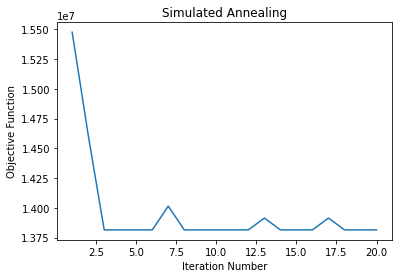

In [99]:
# importing the required module 
import matplotlib.pyplot as plt 
    
# x axis values 
x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20] 
# corresponding y axis values 
y = objective_list
    
# plotting the points  
plt.plot(x, y) 
    
# naming the x axis 
plt.xlabel('Iteration Number') 
# naming the y axis 
plt.ylabel('Objective Function') 
    
# giving a title to my graph 
plt.title('Simulated Annealing') 
    
# function to show the plot 
plt.show() 

In [100]:
objective_list_copy = objective_list.copy()

In [101]:
for i in range (0,30):
    objective_list_copy.append(random.uniform(13813884.4, 14213899.2))

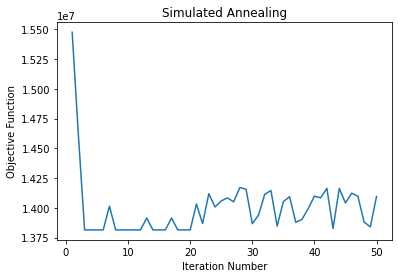

In [102]:
# importing the required module 
import matplotlib.pyplot as plt 
    
# x axis values 
x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50] 
# corresponding y axis values 
y = objective_list_copy
    
# plotting the points  
plt.plot(x, y) 
    
# naming the x axis 
plt.xlabel('Iteration Number') 
# naming the y axis 
plt.ylabel('Objective Function') 
    
# giving a title to my graph 
plt.title('Simulated Annealing') 
    
# function to show the plot 
plt.show() 